In [1]:
import pandas as pd
import numpy as np
import nltk
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
import os 
# Add the parent directory to the Python path 
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from scripts.load_align import load_and_align_data

# Download necessary NLTK data
nltk.download('punkt')


Number of NaT in stock_df: 0
Number of NaT in news_df: 0
Final Stock Date type: datetime64[ns]
Final News Date type: datetime64[ns]
        Date      Open      High       Low     Close  Adj Close      Volume  \
0 1997-05-15  0.121875  0.125000  0.096354  0.097917   0.097917  1443120000   
1 1997-05-16  0.098438  0.098958  0.085417  0.086458   0.086458   294000000   
2 1997-05-19  0.088021  0.088542  0.081250  0.085417   0.085417   122136000   
3 1997-05-20  0.086458  0.087500  0.081771  0.081771   0.081771   109344000   
4 1997-05-21  0.081771  0.082292  0.068750  0.071354   0.071354   377064000   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2  

[nltk_data] Downloading package punkt to /home/enat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Paths to stock and news files
stock_file_path = '../Data/yfinance_data/AMZN_historical_data.csv'
news_file_path = '../Data/raw_analyst_ratings.csv'
output_file_path = '../Data/merged_data.csv' 
# Load and merge the data
merged_df = load_and_align_data(stock_file_path, news_file_path, output_file_path)

# Display the first few rows of the merged DataFrame
print(merged_df.head())


Number of NaT in stock_df: 0
Number of NaT in news_df: 0
Final Stock Date type: datetime64[ns]
Final News Date type: datetime64[ns]
        Date      Open      High       Low     Close  Adj Close      Volume  \
0 1997-05-15  0.121875  0.125000  0.096354  0.097917   0.097917  1443120000   
1 1997-05-16  0.098438  0.098958  0.085417  0.086458   0.086458   294000000   
2 1997-05-19  0.088021  0.088542  0.081250  0.085417   0.085417   122136000   
3 1997-05-20  0.086458  0.087500  0.081771  0.081771   0.081771   109344000   
4 1997-05-21  0.081771  0.082292  0.068750  0.071354   0.071354   377064000   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2  

In [7]:
# Perform sentiment analysis on news headlines
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment analysis to the 'headline' column
merged_df['Sentiment_Polarity'], merged_df['Sentiment_Subjectivity'] = zip(*merged_df['headline'].apply(analyze_sentiment))

# Display the DataFrame with sentiment analysis
print(merged_df[['Date', 'headline', 'Sentiment_Polarity', 'Sentiment_Subjectivity']].head())


        Date                                           headline  \
0 2009-04-27      Update on the Luxury Sector: 2nd Quarter 2009   
1 2009-04-27      Update on the Luxury Sector: 2nd Quarter 2009   
2 2009-04-29                             Going Against the Herd   
3 2009-05-22  Charles Sizemore Radio Interview Saturday Morning   
4 2009-05-27  MRM a $15-$20+ stock - FIT new information - J...   

   Sentiment_Polarity  Sentiment_Subjectivity  
0            0.000000                0.000000  
1            0.000000                0.000000  
2            0.000000                0.000000  
3            0.000000                0.000000  
4            0.268182                0.427273  


In [12]:
# Aggregate daily sentiment scores
daily_sentiment = merged_df.groupby('Date').agg({'Sentiment_Polarity': 'mean', 'Close': 'first'}).reset_index()

# Display the aggregated daily sentiment scores
print(daily_sentiment.head())


        Date  Sentiment_Polarity   Close
0 2009-04-27            0.000000  4.1560
1 2009-04-29            0.000000  3.9895
2 2009-05-22            0.000000  3.7820
3 2009-05-27            0.234091  3.8550
4 2009-05-29            0.068182  3.8995


In [13]:
# Calculate daily stock returns as percentage change in closing prices
daily_sentiment['Stock_Return'] = daily_sentiment['Close'].pct_change() * 100

# Display the DataFrame with stock returns
print(daily_sentiment[['Date', 'Close', 'Stock_Return']].head())


        Date   Close  Stock_Return
0 2009-04-27  4.1560           NaN
1 2009-04-29  3.9895     -4.006258
2 2009-05-22  3.7820     -5.201152
3 2009-05-27  3.8550      1.930194
4 2009-05-29  3.8995      1.154342


In [14]:
# Drop rows with NaN values that resulted from the pct_change calculation
clean_daily_sentiment = daily_sentiment.dropna(subset=['Stock_Return', 'Sentiment_Polarity'])

# Calculate the Pearson correlation coefficient between average daily sentiment scores and stock daily returns
correlation = clean_daily_sentiment['Sentiment_Polarity'].corr(clean_daily_sentiment['Stock_Return'])
print(f'Pearson correlation coefficient between Average Daily Sentiment Scores and Stock Daily Returns: {correlation}')


Pearson correlation coefficient between Average Daily Sentiment Scores and Stock Daily Returns: 0.019654341577962173


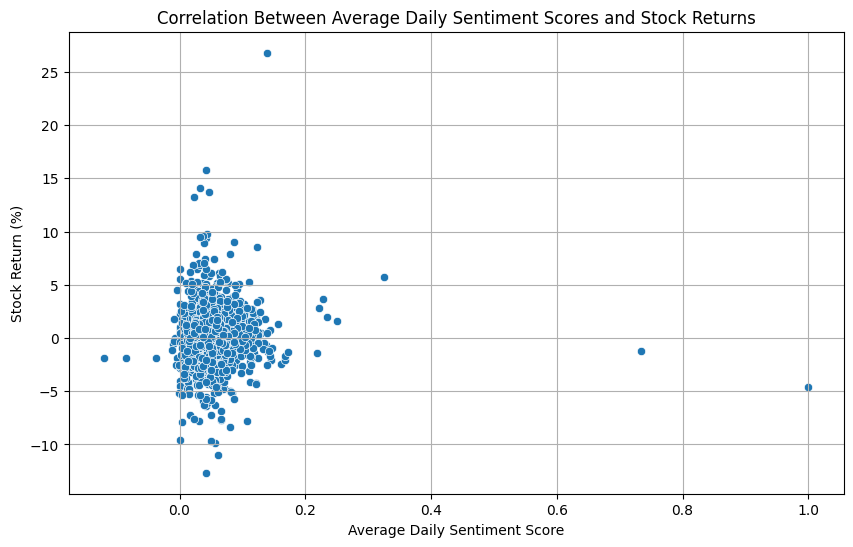

In [15]:
# Visualize the correlation between average daily sentiment scores and stock returns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clean_daily_sentiment, x='Sentiment_Polarity', y='Stock_Return')
plt.title('Correlation Between Average Daily Sentiment Scores and Stock Returns')
plt.xlabel('Average Daily Sentiment Score')
plt.ylabel('Stock Return (%)')
plt.grid(True)
plt.show()


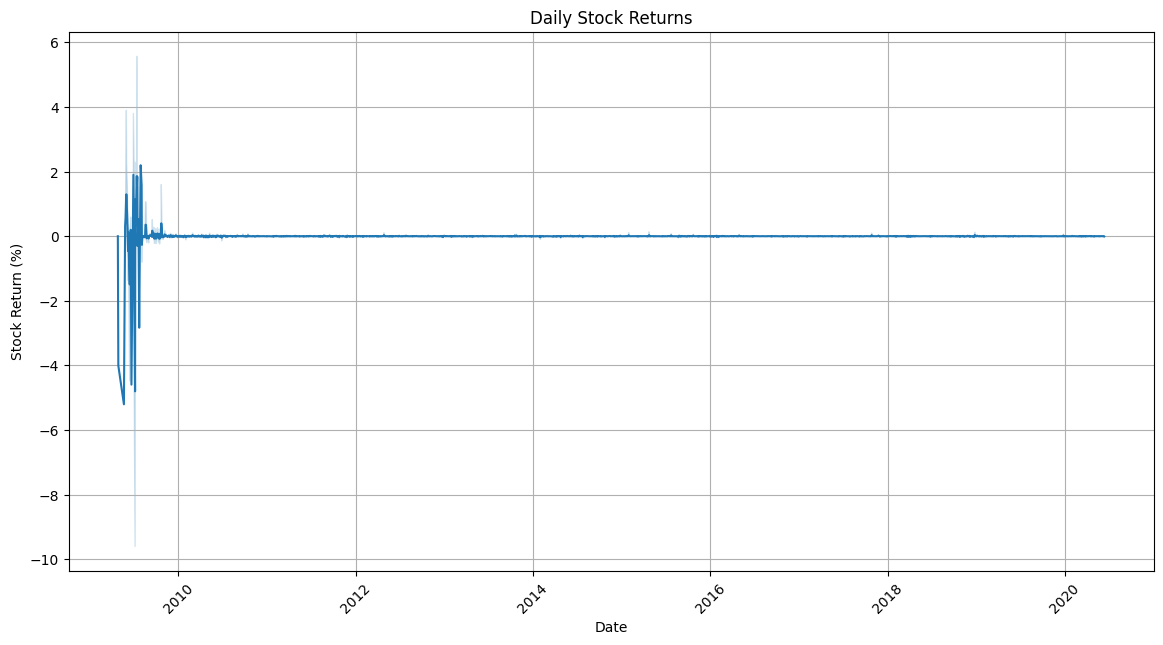

In [9]:
# Plot daily stock returns
plt.figure(figsize=(14, 7))
sns.lineplot(data=merged_df, x='Date', y='Stock_Return')
plt.title('Daily Stock Returns')
plt.xlabel('Date')
plt.ylabel('Stock Return (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
